In [1]:
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=10 --xla_cpu_enable_fast_math=true'

import jax
print(jax.devices())

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np
import jax.numpy as jnp
import jax 
from jax import grad, vmap
jax.config.update("jax_enable_x64", True)


import matplotlib.pyplot as plt

import scipy.interpolate as interp
import scipy.integrate as integ
import scipy.linalg as sla

import fisher_jim_tgr_2par as lib
import pycbc.conversions

import astropy.units as u
from astropy import constants as const

Ms = (u.Msun * const.G / const.c**3 ).si.value
from datetime import datetime
datestr = datetime.now().strftime('%m-%d-%y')

import matplotlib as mpl
from matplotlib.legend_handler import HandlerLine2D, HandlerPatch

def reset_matplotlib():
    # Reset all matplotlib settings to defaults
    mpl.rcdefaults()

    # Create a default handler map and update it globally
    default_handler_map = {
        mpl.lines.Line2D: HandlerLine2D(numpoints=1),
        mpl.patches.Patch: HandlerPatch()
    }

    # Update the default handler map globally
    mpl.legend.Legend.update_default_handler_map(default_handler_map)

# Call this function at the start of your script to globally reset settings
reset_matplotlib()

import getpass
uname = getpass.getuser()
figtype = None #"notebook"

# plt.style.use('default')
import scienceplots
if uname == 'darkknight':
    if figtype == "notebook":
        plt.style.use(['science','ieee','notebook'])
        plt.rcParams.update({'figure.dpi': 185/1.75/1.5})
    else:
        plt.style.use(['science','ieee'])
        plt.rcParams.update({'figure.dpi': 185/1.75*1.2})
elif uname == 'brian':
    if figtype == "notebook":
        plt.style.use(['science','ieee','notebook'])
        plt.rcParams.update({'figure.dpi': 185/1.75/1.5})
    else:
        plt.style.use(['science','ieee'])
        plt.rcParams.update({'figure.dpi': 254})
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
plt.rcParams.update({'font.serif': 'Times', 'font.family' : 'serif'})


RuntimeError: This version of jaxlib was built using AVX instructions, which your CPU and/or operating system do not support. This error is frequently encountered on macOS when running an x86 Python installation on ARM hardware. In this case, try installing an ARM build of Python. Otherwise, you may be able work around this issue by building jaxlib from source.

In [2]:
# Ground stuff
n_freq = 2000
fmin = 10.
fmax = 1000.
freqs = jnp.logspace(jnp.log10(fmin), jnp.log10(fmax), num = int(n_freq))


full_str = ["M_c", "eta", "d_L", "ra", "dec", "iota", "psi", "t_c", "phase_c", "zco", "rng", "Mc_source", "snr_H1", "snr_L1", "snr_V1", "snr_t"]
names = full_str[0:9]
# data = np.loadtxt("data/events.txt")
data = jnp.array(np.loadtxt("data/5-year-data-O3/5-year-data-O3-events.txt"))
# data = jnp.array(nnp.loadtxt("data/5-year-data-CE/5-year-data-CE-events.txt"))

psd = lib.read_mag(freqs, "curves/o3_l1.txt")**2
# psd = lib.read_mag(freqs, "../curves/ce1.txt")**2

data_150914 = np.array(data[0])
data_150914[0] = 30
q  = 0.79
data_150914[1] = q/(1+q)**2
data_150914[2] = 390

idx = '150914'
if idx=='150914':
    dat = jnp.array(data_150914)

red_param = dict(zip(names, jnp.array(dat).T))

NameError: name 'jnp' is not defined

In [3]:
from jimgw.detector import H1, L1, V1
from jimgw.waveform import RippleIMRPhenomPv2, RippleIMRPhenomD
import jax
import jax.numpy as jnp
from jax import grad, vmap

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", True)
# Assuming 'waveform' is defined elsewhere, or you can import it
waveform = RippleIMRPhenomPv2(f_ref=20)
# waveform = RippleIMRPhenomD(f_ref=20)

def get_h_slow(x, f, detector):
    # Set default parameters
    

    ff = jnp.array([f])
    h_sky = waveform(ff, x)
    align_time = jnp.exp(-1j * 2 * jnp.pi * ff * (x['epoch'] + x['t_c']))
    signal = detector.fd_response(ff, h_sky, x) * align_time
    return signal[0]

def get_dh_nojit(x, f, detector):
    # Define a function to compute the real and imaginary parts
    def h_real(x, f):
        return get_h_slow(x, f, detector).real

    def h_imag(x, f):
        return get_h_slow(x, f, detector).imag

    # Compute gradients
    ur = vmap(grad(h_real), in_axes=(None, 0))(x, f)
    ui = vmap(grad(h_imag), in_axes=(None, 0))(x, f)
    dh = {key: ur.get(key, 0) + 1j * ui.get(key, 0) for key in x}
    return dh

# Create generic functions for each detector
def get_h_nojit(x, f, detector):
    return vmap(lambda f_single: get_h_slow(x, f_single, detector))(f)



red_param = dict(zip(names, jnp.array(dat).T))
epsilon = jnp.array(1e-6)
for key in ['s1_x', 's1_y', 's1_z', 's2_x', 's2_y', 's2_z']:
        red_param[key] = epsilon
zero_vector = jnp.array(0.)
for key in ['gmst', 'epoch']:
    red_param[key] = zero_vector

x = red_param.copy()
# x['s1_z'] = 0.2

get_h = jax.jit(get_h_nojit, static_argnums=2)
get_dh = jax.jit(get_dh_nojit, static_argnums=2)
a = get_h(x, freqs,H1)
b = get_dh(x, freqs,H1)

ModuleNotFoundError: No module named 'jimgw.detector'

In [4]:
paramx = ['M_c', 'eta', 'd_L', 'ra', 'dec', 'iota', 'psi', 't_c', 'phase_c', 'dphi_rec']
log_flag =  {paramx[i] : 0 for i in range(len(paramx))}; log_flag["M_c"] = 1; log_flag["d_L"] = 1
x = red_param.copy()

NameError: name 'red_param' is not defined

In [5]:
k_inj = 1
k_rec = 3

In [53]:
def compute_mm(k_inj, k_rec):
    paramx = ['M_c', 'eta', 'd_L', 'ra', 'dec', 'iota', 'psi', 't_c', 'phase_c', 'dphi_rec']
    log_flag =  {paramx[i] : 0 for i in range(len(paramx))}; log_flag["M_c"] = 1; log_flag["d_L"] = 1
    x = red_param.copy()


    dpsi_inj = 0.1*lib.get_dpsi_ppe(freqs, red_param, k_inj)
    dpsi_rec = lib.get_dpsi_ppe(freqs, red_param, k_rec)
    dephasing_inj = 1j* dpsi_inj #jnp.exp(1j*dpsi_inj)
    dephasing_rec = 1j* dpsi_rec #jnp.exp(1j*dpsi_rec)
    
    h_H1 = get_h(x, freqs,H1)
    h_L1 = get_h(x, freqs,L1)
    h_V1 = get_h(x, freqs,V1)
    
    Dh_H1 = dephasing_inj*h_H1
    Dh_L1 = dephasing_inj*h_L1
    Dh_V1 = dephasing_inj*h_V1
    
    dh_H1 = get_dh(x, freqs,H1)
    dh_L1 = get_dh(x, freqs,L1)
    dh_V1 = get_dh(x, freqs,V1)
    
    
    dh_H1['dphi_rec'] = 1j*dpsi_rec*h_H1
    dh_L1['dphi_rec'] = 1j*dpsi_rec*h_L1
    dh_V1['dphi_rec'] = 1j*dpsi_rec*h_V1

    idx_x = {paramx[i] : i for i in range(len(paramx))}
    fi_H1 = lib.fish(freqs, dh_H1, x, idx_x, psd, log_flag)
    fi_L1 = lib.fish(freqs, dh_L1, x, idx_x, psd, log_flag)
    fi_V1 = lib.fish(freqs, dh_V1, x, idx_x, psd, log_flag)
    fi = fi_H1 + fi_L1 + fi_V1
    
    #do this afterward I unfortunately already implemented it 
    for i in paramx:
        if log_flag[i]:
            dh_H1[i] = dh_H1[i] * x[i]
            dh_L1[i] = dh_L1[i] * x[i]
            dh_V1[i] = dh_V1[i] * x[i]

    def compute_bias(dhdtheta, Dh, psd, freqs, idx_par):
        res = { key : jnp.real(lib.innprod(dhdtheta[key], Dh, psd, freqs)) for key in idx_par.keys()}
        bias = [res[key] for key, index in sorted(idx_par.items(), key=lambda item: item[1])]
        return jnp.real(jnp.array(bias))
    
    
    
    V = compute_bias(dh_H1, Dh_H1, psd, freqs, idx_x) + compute_bias(dh_L1, Dh_L1, psd, freqs, idx_x) + compute_bias(dh_V1, Dh_V1, psd, freqs, idx_x)
    V = np.array(V)
    lam = V @ sla.inv(fi)
    
    dh = np.array([dh_H1[s] for s in idx_x])
    
    dhtot = Dh_H1
    dhperp = (dhtot - lam @ dh)
    dhpara = lam @ dh
    
    mm = (1/2 * lib.innprod(dhperp,dhperp, psd,freqs)/lib.innprod(h_H1,h_H1,psd,freqs))
    return mm 

ii = [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7]

mmarr = np.zeros((len(ii),len(ii)))
# compute_mm(1, 3)
for i in ii:
    for j in ii:
        mmarr[i,j] = compute_mm(i, j)

In [60]:
ii = [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7]

mmarr = np.zeros((len(ii),len(ii)))
# compute_mm(1, 3)
for i in ii:
    for j in ii:
        mmarr[i,j] = np.real(compute_mm(i, j))

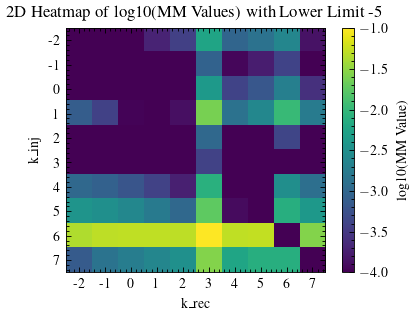

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming mmarr has been computed as a 2D array with real values
# Replace any non-positive values with a small positive number to avoid issues with log10
mmarr_safe = np.where(mmarr > 0, mmarr, np.nan)  # replace non-positive with NaN
log_mmarr = np.log10(mmarr_safe)

# Create the heatmap with a color range limited to -5 and max value of the data
plt.imshow(log_mmarr, cmap='viridis', interpolation='nearest', aspect='auto', vmin=-4, vmax=np.nanmax(log_mmarr))

# Add color bar for reference
plt.colorbar(label='log10(MM Value)')

# Label axes
plt.xlabel("k_rec")
plt.ylabel("k_inj")

# Set x and y ticks to match your ii indices
plt.xticks(ticks=np.arange(len(ii)), labels=ii)
plt.yticks(ticks=np.arange(len(ii)), labels=ii)

# Add title
plt.title("2D Heatmap of log10(MM Values) with Lower Limit -5")

# Show the plot
plt.show()


old stuff

In [25]:
dpsi_inj = 0.1*lib.get_dpsi_ppe(freqs, red_param, k_inj)
dpsi_rec = lib.get_dpsi_ppe(freqs, red_param, k_rec)
dephasing_inj = jnp.exp(1j*dpsi_inj)
dephasing_rec = jnp.exp(1j*dpsi_rec)

h_H1 = get_h(x, freqs,H1)
h_L1 = get_h(x, freqs,L1)
h_V1 = get_h(x, freqs,V1)

Dh_H1 = dephasing*h_H1
Dh_L1 = dephasing*h_L1
Dh_V1 = dephasing*h_V1

dh_H1 = get_dh(x, freqs,H1)
dh_L1 = get_dh(x, freqs,L1)
dh_V1 = get_dh(x, freqs,V1)


dh_H1['dphi_rec'] = 1j*dpsi_rec*h_H1
dh_L1['dphi_rec'] = 1j*dpsi_rec*h_L1
dh_V1['dphi_rec'] = 1j*dpsi_rec*h_V1

In [26]:
idx_x = {paramx[i] : i for i in range(len(paramx))}
fi_H1 = lib.fish(freqs, dh_H1, x, idx_x, psd, log_flag)
fi_L1 = lib.fish(freqs, dh_L1, x, idx_x, psd, log_flag)
fi_V1 = lib.fish(freqs, dh_V1, x, idx_x, psd, log_flag)
fi = fi_H1 + fi_L1 + fi_V1

#do this afterward I unfortunately already implemented it 
for i in paramx:
    if log_flag[i]:
        dh_H1[i] = dh_H1[i] * x[i]
        dh_L1[i] = dh_L1[i] * x[i]
        dh_V1[i] = dh_V1[i] * x[i]

In [32]:
def compute_bias(dhdtheta, Dh, psd, freqs, idx_par):
    res = { key : jnp.real(lib.innprod(dhdtheta[key], Dh, psd, freqs)) for key in idx_par.keys()}
    bias = [res[key] for key, index in sorted(idx_par.items(), key=lambda item: item[1])]
    return jnp.real(jnp.array(bias))



V = compute_bias(dh_H1, Dh_H1, psd, freqs, idx_x) + compute_bias(dh_L1, Dh_L1, psd, freqs, idx_x) + compute_bias(dh_V1, Dh_V1, psd, freqs, idx_x)
V = np.array(V)
lam = V @ sla.inv(fi)

dh = np.array([dh_H1[s] for s in idx_x])

dhtot = Dh_H1
dhperp = (dhtot - lam @ dh)
dhpara = lam @ dh

mm = (1/2 * lib.innprod(dhperp,dhperp, psd,freqs)/lib.innprod(h_H1,h_H1,psd,freqs))